<a href="https://colab.research.google.com/github/Janina712/MLTSA22_JBoecher/blob/main/HW7/JBoecher_HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This is an exercise on feature extractoin and Gaussian Processes interpolation of sparse time series.

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in light emission in 6 different bands (i.e. wavelength ranges). The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good friend Gautham Narayan) to get started and ingest and preprocess the PLASTiCC challenge data. If you are not familiar with classes (object oriented syntax) do not worry about it: I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and fit the time series with Gaussian Processes. 



In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import random as random

%pylab inline


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# TASK I :  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018
 or from zenodo
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ
 Choose how to do it but make sure that it is a reproducible way. You will need the **training data and the metadata files** only - you wont need to use the test data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/ColabNotebooks

/content/drive/MyDrive/ColabNotebooks


In [4]:
lcvs = pd.read_csv("plasticc_train_lightcurves.csv.gz")

In [5]:
lcvs.head() 

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [6]:
print("The shape of light curves dataset is:", lcvs.shape)

The shape of light curves dataset is: (1421705, 6)


In [7]:
#check missing values
lcvs.isna().sum()

object_id        0
mjd              0
passband         0
flux             0
flux_err         0
detected_bool    0
dtype: int64

Read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands 

In [8]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [9]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [10]:
metadata = pd.read_csv("plasticc_train_metadata.csv.gz")
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
print("The metadata columns are: ", metadata.columns)

The metadata columns are:  Index(['object_id', 'ra', 'decl', 'ddf_bool', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target',
       'true_target', 'true_submodel', 'true_z', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y'],
      dtype='object')


In [12]:
print("The metadata dataset contains features: ", metadata.shape[1])

The metadata dataset contains features:  26


# TASK II : data exploration and visualization - plot some time series 
Visualize my data to get a sense of what we are working with. 





Plot light curves for 10 objects. 

In [13]:
unique_ID = lcvs.object_id.unique()

In [14]:
#pick 10 random objects to plot
idx2plot = []

for i in range(0,10):
    idx2plot.append(random.choice(unique_ID))

print(idx2plot)

[128971260, 99050, 95499260, 100122518, 61843700, 76897889, 58856330, 75779181, 134380, 99390548]


**Comment:** Select 10 ts randomly from the dataset to use as subset. Create sub-data frames of each of these objects below.

In [15]:
# Create sub-dataframe for each object
for i in range(1,10):
    locals()["obj"+str(i)] = lcvs.loc[lcvs['object_id'] == idx2plot[i]]


In [16]:
# just to be safe
obj1 = lcvs.loc[lcvs['object_id'] == idx2plot[0]]
obj2 = lcvs.loc[lcvs['object_id'] == idx2plot[1]]
obj3 = lcvs.loc[lcvs['object_id'] == idx2plot[2]]
obj4 = lcvs.loc[lcvs['object_id'] == idx2plot[3]]
obj5 = lcvs.loc[lcvs['object_id'] == idx2plot[4]]
obj6 = lcvs.loc[lcvs['object_id'] == idx2plot[5]]
obj7 = lcvs.loc[lcvs['object_id'] == idx2plot[6]]
obj8 = lcvs.loc[lcvs['object_id'] == idx2plot[7]]
obj9 = lcvs.loc[lcvs['object_id'] == idx2plot[8]]
obj10 = lcvs.loc[lcvs['object_id'] == idx2plot[9]]

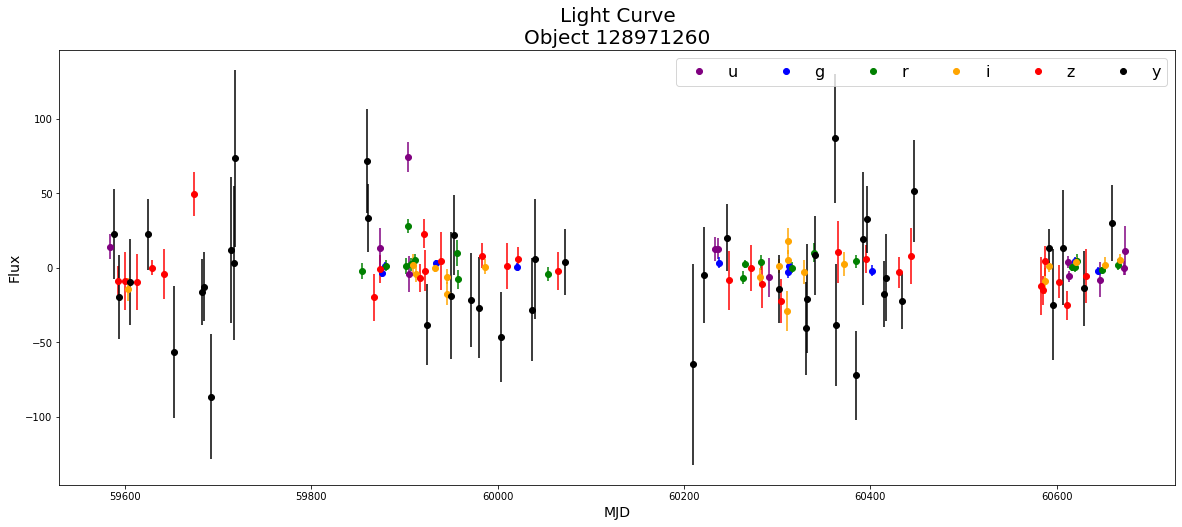

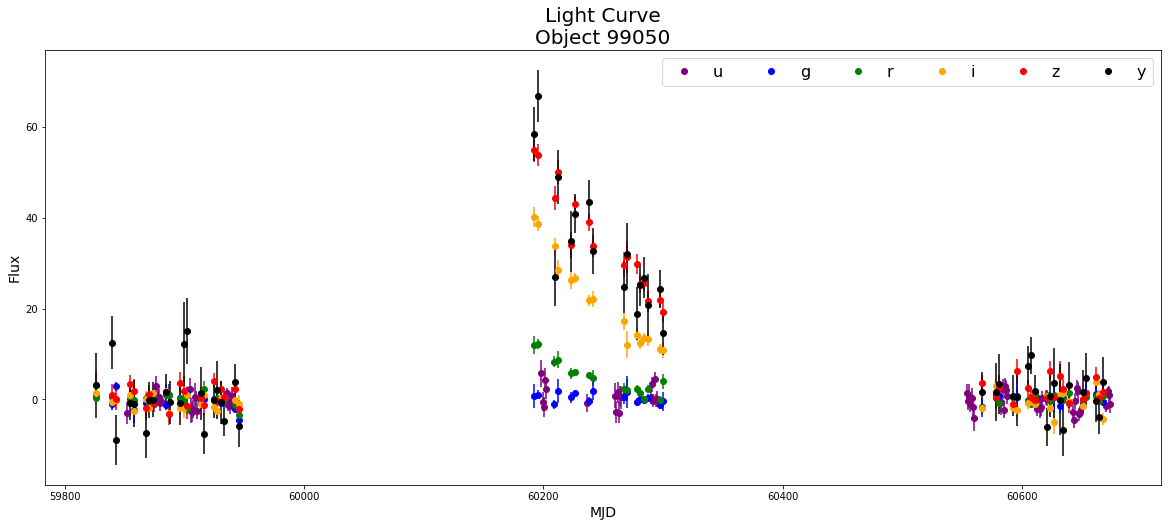

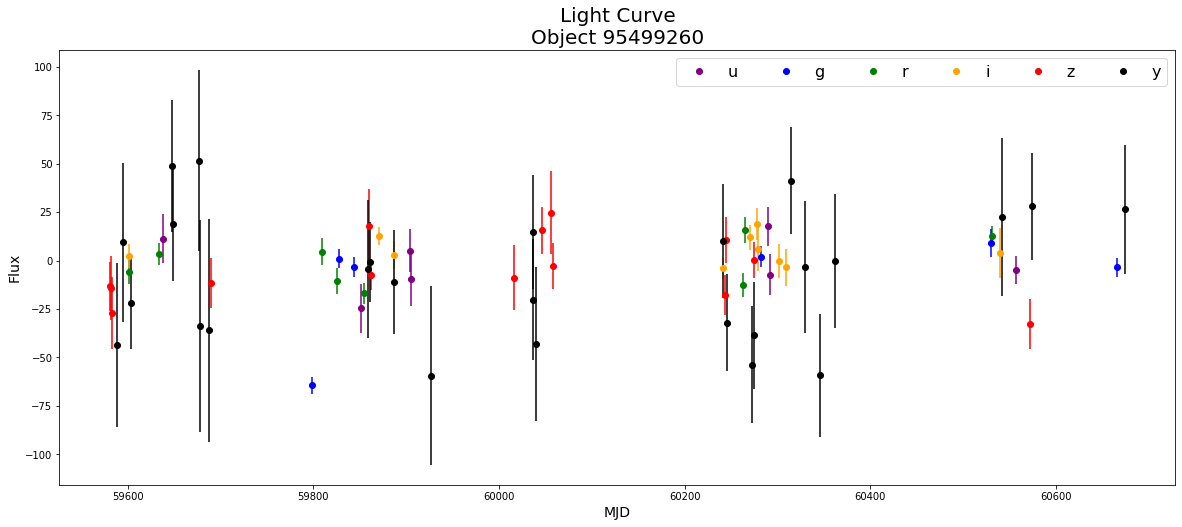

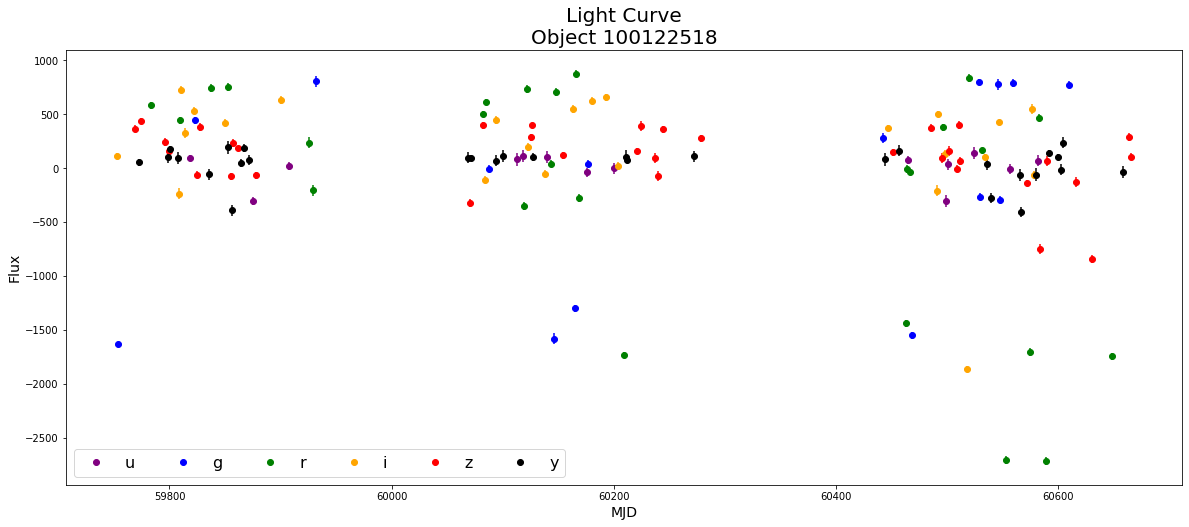

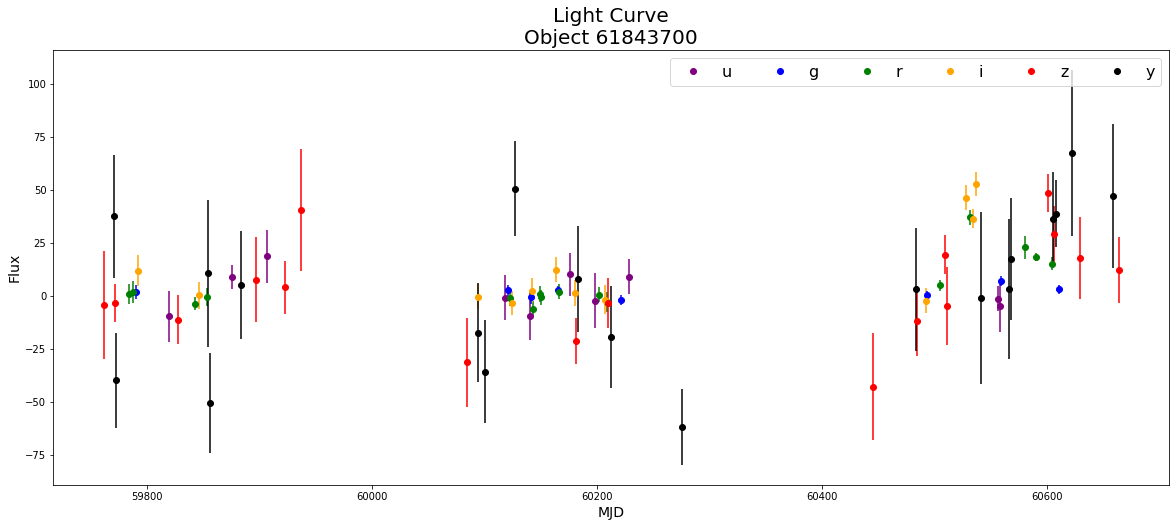

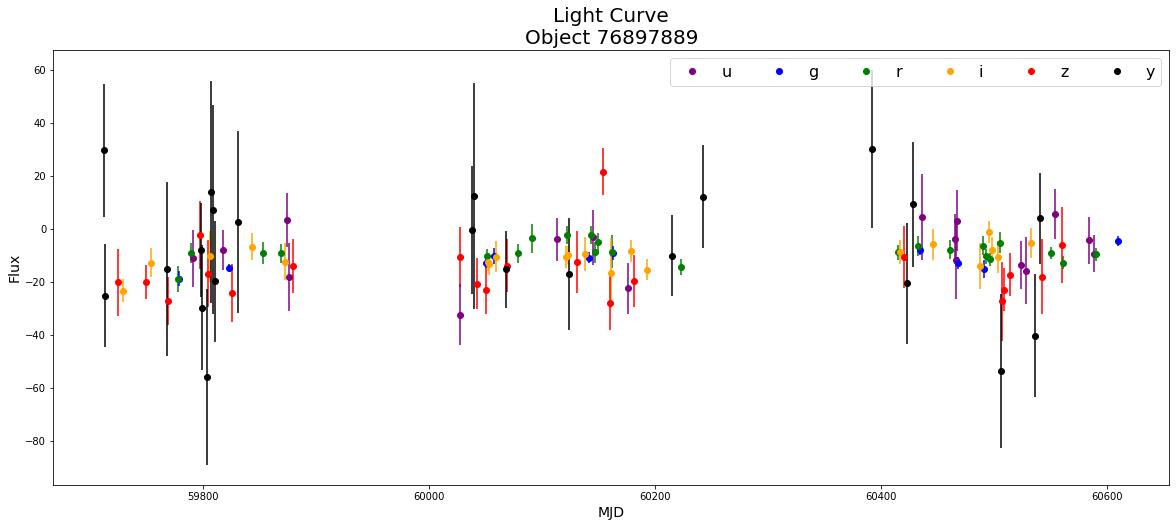

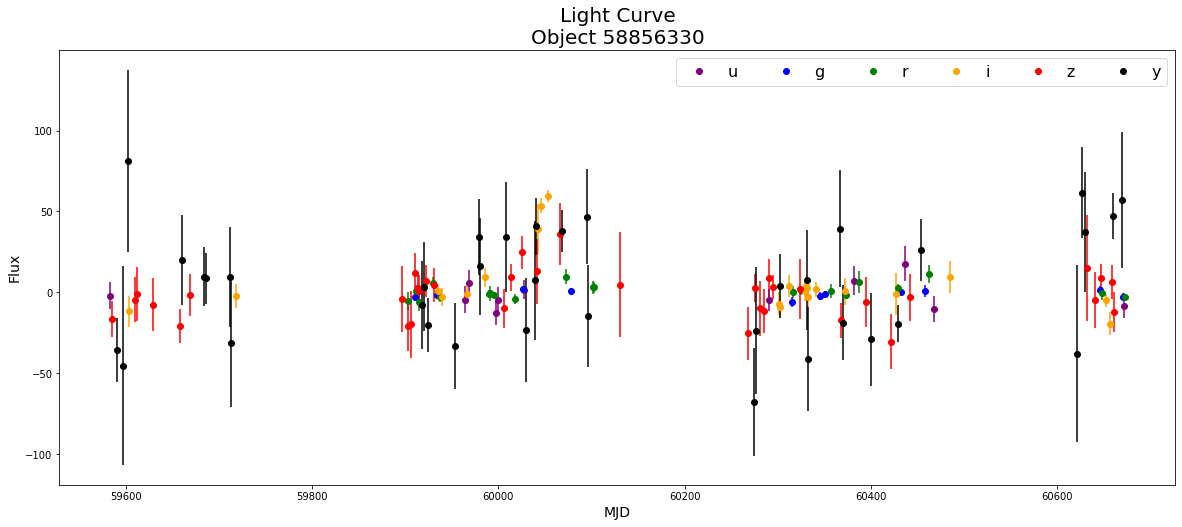

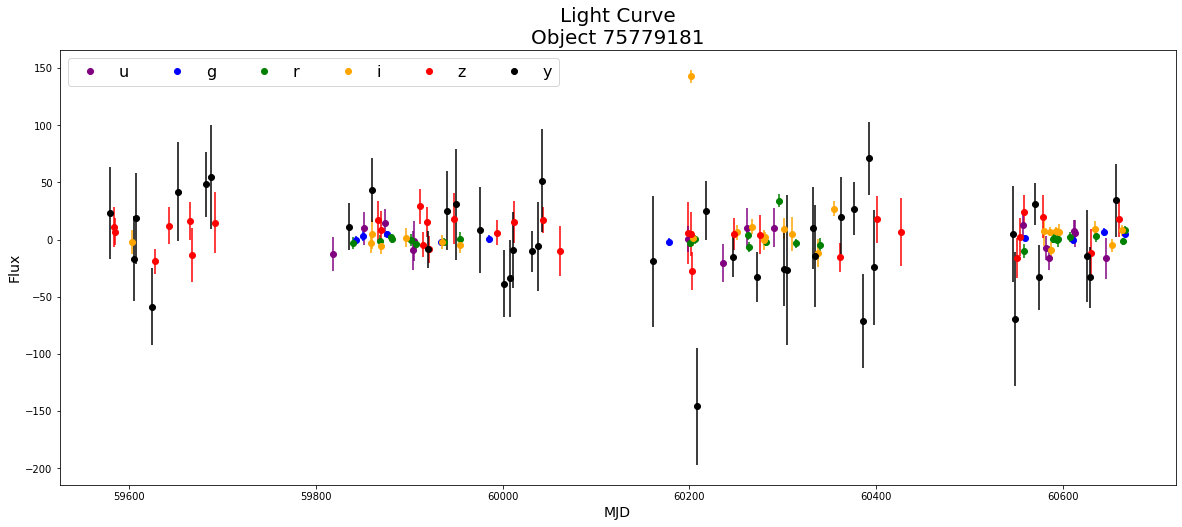

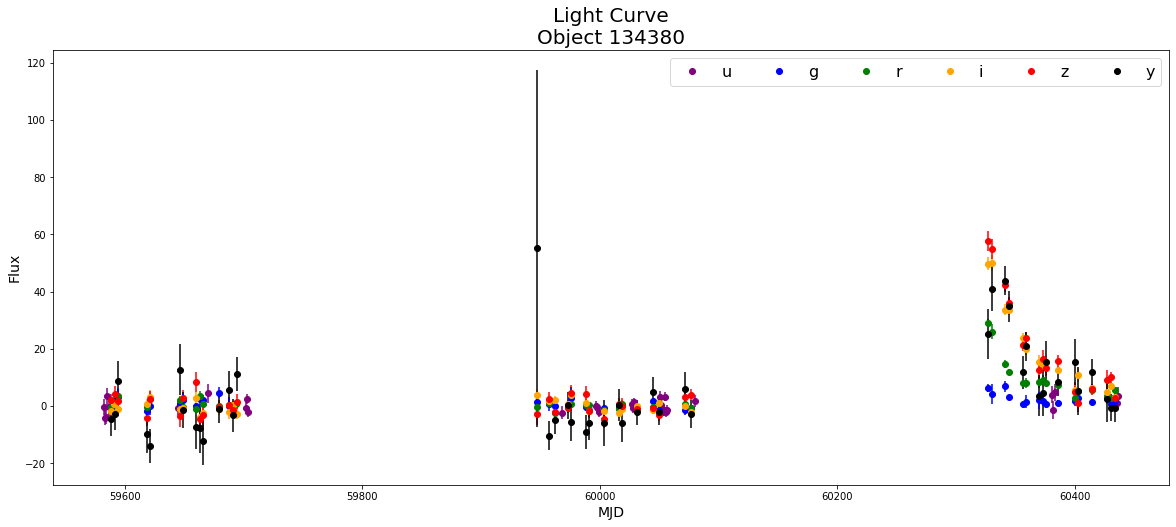

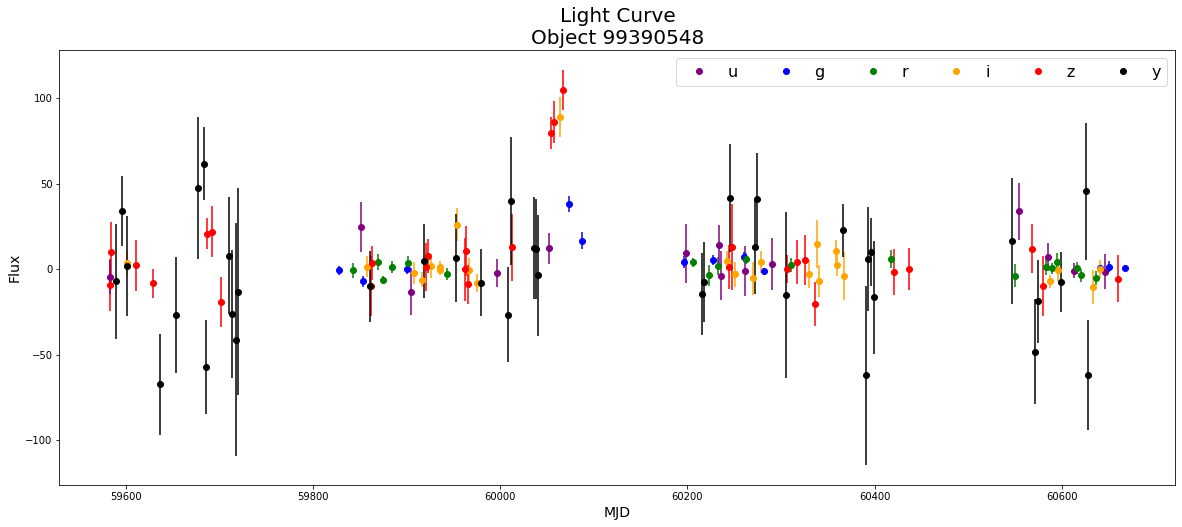

In [668]:
for i in range(1,11):
    thisObj = locals()["obj"+str(i)]

    purple = thisObj.loc[thisObj["passband"] == 0]
    blue = thisObj.loc[thisObj["passband"] == 1]
    green = thisObj.loc[thisObj["passband"] == 2]
    orange = thisObj.loc[thisObj["passband"] == 3]
    red = thisObj.loc[thisObj["passband"] == 4]
    black = thisObj.loc[thisObj["passband"] == 5]

    pl.figure(figsize=(20,8))
    pl.plot(purple.mjd, purple.flux, 'o', color = "purple", label = "u")
    pl.plot(blue.mjd, blue.flux, 'bo', label = "g")
    pl.plot(green.mjd, green.flux, 'go', label = "r")
    pl.plot(orange.mjd, orange.flux, 'o', color = "orange", label = "i")
    pl.plot(red.mjd, red.flux, 'ro', label = "z")
    pl.plot(black.mjd, black.flux, 'ko', label = "y")

    # errorbars
    pl.errorbar(green.mjd, green.flux, yerr = green.flux_err, fmt = 'none', ecolor= 'g')
    pl.errorbar(orange.mjd, orange.flux, yerr = orange.flux_err, fmt = 'none', ecolor= 'orange')
    pl.errorbar(red.mjd, red.flux, yerr = red.flux_err, fmt = 'none', ecolor= 'r')
    pl.errorbar(black.mjd, black.flux, yerr = black.flux_err, fmt = 'none', ecolor= 'k')
    pl.errorbar(purple.mjd, purple.flux, yerr = purple.flux_err, fmt = 'none', ecolor= 'purple')
    pl.errorbar(blue.mjd, blue.flux, yerr = blue.flux_err, fmt = 'none', ecolor= 'b')

    pl.title(f"Light Curve\nObject {idx2plot[i-1]}", size = 20);
    pl.xlabel('MJD', size = 14)
    pl.ylabel('Flux', size = 14)
    pl.legend(ncol = 6, prop={'size': 16});


**Fig. 1.** Plot of 10 randomly selected time series objects. Each object represents a light curve. The flux is the dependent variable on the y-axis and mjd is the time measure on the x-axis. Each light curve consists of 6 passbands (u, g, r, i, z, and y). They are plotted separately for each object in its respecitve color. The variable flux_err was used for plotting the errorbars.

A notable characteristic of all plotted ts is that the data points occur in mjd-constrained clusters, e.g., blocks of data points are interspersed by empty blocks (horizontally). Further, most plots exhibit a periodic pattern. 

Domain knowledge would help to interpret these characteristics. 

Plot explicitly object 84716

In [28]:
obj = lcvs.loc[lcvs['object_id'] == 84716]

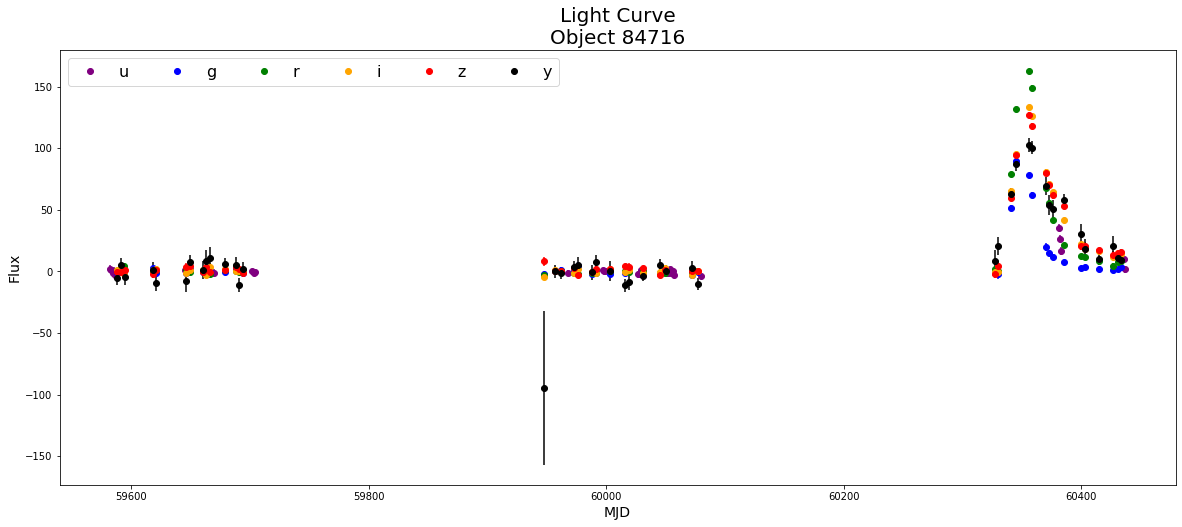

In [178]:
purple = obj.loc[obj["passband"] == 0]
blue = obj.loc[obj["passband"] == 1]
green = obj.loc[obj["passband"] == 2]
orange = obj.loc[obj["passband"] == 3]
red = obj.loc[obj["passband"] == 4]
black = obj.loc[obj["passband"] == 5]

pl.figure(figsize=(20,8))
pl.plot(purple.mjd, purple.flux, 'o', color = "purple", label = "u")
pl.plot(blue.mjd, blue.flux, 'bo', label = "g")
pl.plot(green.mjd, green.flux, 'go', label = "r")
pl.plot(orange.mjd, orange.flux, 'o', color = "orange", label = "i")
pl.plot(red.mjd, red.flux, 'ro', label = "z")
pl.plot(black.mjd, black.flux, 'ko', label = "y")

# errorbars
pl.errorbar(green.mjd, green.flux, yerr = green.flux_err, fmt = 'none', ecolor= 'g')
pl.errorbar(orange.mjd, orange.flux, yerr = orange.flux_err, fmt = 'none', ecolor= 'orange')
pl.errorbar(red.mjd, red.flux, yerr = red.flux_err, fmt = 'none', ecolor= 'r')
pl.errorbar(black.mjd, black.flux, yerr = black.flux_err, fmt = 'none', ecolor= 'k')
pl.errorbar(purple.mjd, purple.flux, yerr = purple.flux_err, fmt = 'none', ecolor= 'purple')
pl.errorbar(blue.mjd, blue.flux, yerr = blue.flux_err, fmt = 'none', ecolor= 'b')

pl.title(f"Light Curve\nObject 84716", size = 20);
pl.xlabel('MJD', size = 14)
pl.ylabel('Flux', size = 14)
pl.legend(ncol = 6, prop={'size': 16});

**Fig. 2.** Plot of object 84716. The object represents a light curve. The flux is the dependent variable on the y-axis and mjd is the time measure on the x-axis. Each light curve consists of 6 passbands (u, g, r, i, z, and y). They are plotted separately in its respecitve color. The variable flux_err was used for plotting the errorbars.

A notable characteristic of the ts is that the data points occur in mjd-constrained clusters, e.g., blocks of data points are interspersed by empty blocks (horizontally). Further, an outlier seems to distort the plot (y data point at around x = 59950 and y = -90), perhaps due to measurement error. An interesting observations happens between x= 60300 and x = 60500. A peak is visbile (or maybe part of a sinusoidal phase?). 

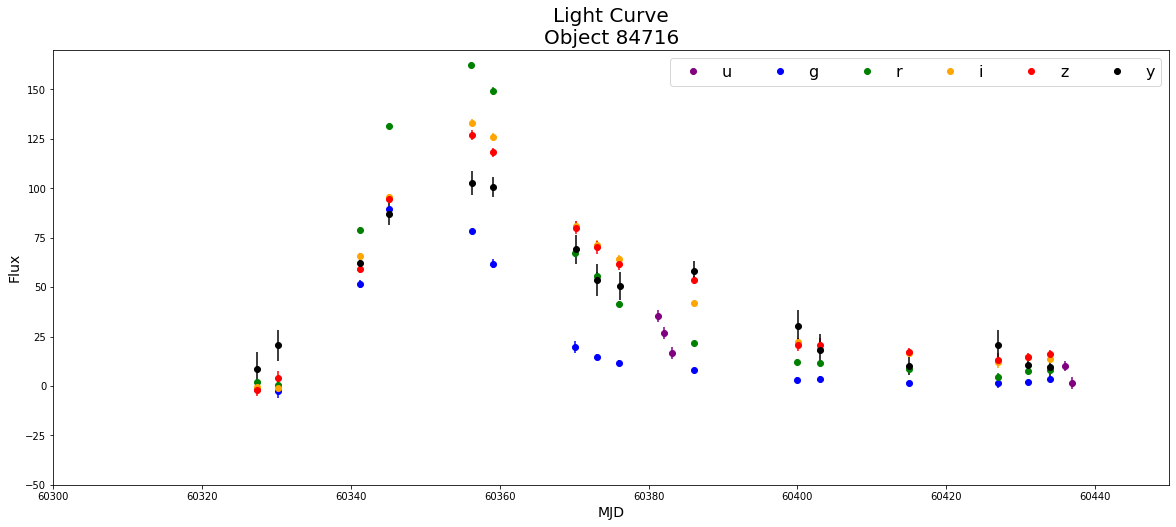

In [324]:
purple = obj.loc[obj["passband"] == 0]
blue = obj.loc[obj["passband"] == 1]
green = obj.loc[obj["passband"] == 2]
orange = obj.loc[obj["passband"] == 3]
red = obj.loc[obj["passband"] == 4]
black = obj.loc[obj["passband"] == 5]

pl.figure(figsize=(20,8))
pl.plot(purple.mjd, purple.flux, 'o', color = "purple", label = "u")
pl.plot(blue.mjd, blue.flux, 'bo', label = "g")
pl.plot(green.mjd, green.flux, 'go', label = "r")
pl.plot(orange.mjd, orange.flux, 'o', color = "orange", label = "i")
pl.plot(red.mjd, red.flux, 'ro', label = "z")
pl.plot(black.mjd, black.flux, 'ko', label = "y")

# errorbars
pl.errorbar(green.mjd, green.flux, yerr = green.flux_err, fmt = 'none', ecolor= 'g')
pl.errorbar(orange.mjd, orange.flux, yerr = orange.flux_err, fmt = 'none', ecolor= 'orange')
pl.errorbar(red.mjd, red.flux, yerr = red.flux_err, fmt = 'none', ecolor= 'r')
pl.errorbar(black.mjd, black.flux, yerr = black.flux_err, fmt = 'none', ecolor= 'k')
pl.errorbar(purple.mjd, purple.flux, yerr = purple.flux_err, fmt = 'none', ecolor= 'purple')
pl.errorbar(blue.mjd, blue.flux, yerr = blue.flux_err, fmt = 'none', ecolor= 'b')

pl.title(f"Light Curve\nObject 84716", size = 20);
pl.xlabel('MJD', size = 14)
pl.xlim([60300, 60450])
pl.ylim([-50, 170])
pl.ylabel('Flux', size = 14)
pl.legend(ncol = 6, prop={'size': 16});

**Fig. 3.** Subset of object 84716. This snippet highlights the interesting data pattern between x = 60300 and x = 60500. A peak in flux values seems to happen at around x = 60355. I don't know how this should be interpreted. 

# TASK III: Extract features

Feature extraction refers to the extraction of statistical features of the datapoints or the generation of low dimensional representations of the data points that can then be passed to a classifier/regression

Extract at least 4 features including at least 1 feature from all three category below

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

Examples of features you can extract:

- **from the original lightcurve**: 
    - mean, 
    - standard deviation, 
    - skewness, 
    - kurthosis, 
    - minimum 
    - maximmum,
    - error on the minimum and 
    - error on the maximum, 
- **from the standardized lightcurve**:
    - median 
    - slope of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl; this is one of the positions in the sky variables: important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)


Extract at least 4 features including 1 features from all three category above: original lcv, standardized lcv, metadata. Justify each feature. Coming up with different features than the ones I suggested is very welcome! Remember that if the features are extracted from the time series there will be 4 features for each passbands.

Note: we are working with bigg-ish data! 
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready. 
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar. 


describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

        

### extract some features from the raw lightcurve - 


higher order moments of the distribution can be obtained with the scipy.stats.moment() function which can be applied to a grouby() object
note that this way you can apply a function that takes only one argument, the argument over which groupby iterates (the flux here). But moments take 2: the value and the moment Create a function call

In [711]:
lcvs

,object_id,mjd,passband,flux,flux_err,detected_bool,flux_std,flux_err_std,flux_std_std,means_std_x,means_std_y,s_std
0,615,59750.4229,2,-544.810303,3.622952,1,-2.485095,0.187110,-0.154566,-0.007584,-0.007584,0.022783
1,615,59750.4306,1,-816.434326,5.553370,1,-3.716007,0.810911,-0.228287,-0.111382,-0.111382,0.163329
2,615,59750.4383,3,-471.385529,3.801213,1,-2.152357,0.244714,-0.134638,-0.043109,-0.043109,0.123523
3,615,59750.4450,4,-388.984985,11.395031,1,-1.778945,2.698601,-0.112274,-0.039569,-0.039569,0.091037
4,615,59752.4070,2,-681.858887,4.041204,1,-3.106154,0.322265,-0.191762,-0.021887,-0.021887,0.079197
...,...,...,...,...,...,...,...,...,...,...,...,...
47083,25039,59767.2968,2,0.181824,0.891787,0,-0.015366,-0.695446,-0.006651,0.190115,0.190115,0.325025
47084,25039,59767.3045,1,1.551395,0.775666,0,-0.009160,-0.732970,-0.006280,0.723482,0.723482,1.747975
47085,25039,59767.3122,3,0.215805,1.349231,0,-0.015212,-0.547627,-0.006642,0.198481,0.198481,0.391876
47086,25039,59767.3233,4,-1.190264,2.154849,0,-0.021584,-0.287297,-0.007024,0.940288,0.940288,2.987312


In [426]:
from scipy import stats 
import math

Initialize dataframe to store all the features:

In [703]:
features = pd.DataFrame()

In [704]:
#example (you can use this code but this wont count for your 4 features)
#means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()

In [ ]:
#example (you can use this code but this wont count for your 4 features)
#def m2(x):
#    return stats.moment(x, moment = 2)

Extract features from raw data: min, max, standard deviation, and mean, as well as error on the mean and maximum

In [705]:
# extract features (min, max, mean)
data_min = lcvs.groupby(["object_id", "passband"], as_index=False)[["flux"]].min()
data_max = lcvs.groupby(["object_id", "passband"], as_index=False)[["flux"]].max()
errors = lcvs.groupby(["object_id", "passband"], as_index=False)[["flux"]].agg(['mean', 'count', 'std'])

In [706]:
# Merge feature with feature dataframe
mins = data_min
mins = mins.rename({'flux': 'mins'}, axis=1)
features = mins

In [707]:
# Merge feature with feature dataframe
maxs = data_max
maxs = maxs.rename({'flux': 'maxs'}, axis=1)
features = features.merge(maxs.maxs, left_index=True, right_index=True)

In [708]:
# Merge feature with feature dataframe
means = data_mean
means = means.rename({'flux': 'means'}, axis=1)
features = features.merge(means.means, left_index=True, right_index=True)

In [617]:
# calculate 95% confidence interval
ci95_hi = []
ci95_lo = []

for i in errors.index:
    m, c, s = errors.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

errors['ci95_hi'] = ci95_hi
errors['ci95_lo'] = ci95_lo

In [619]:
# extract features (error on max and min)
data_max_err = errors.ci95_hi
data_min_err = errors.ci95_lo

Even with the same standard deviation two distribution can be very different. 
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties because outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation). 


In [773]:
# extract features from object 84716
# raw light curve
# mean
data_mean = lcvs.groupby(["object_id", "passband"], as_index = False)[["flux"]].mean()
data_mean.loc[data_mean['object_id'] == 84716]

,object_id,passband,flux


In [624]:
# extract features from object 84716
# raw light curve
# max
data_max = lcvs.groupby(["object_id", "passband"], as_index = False)[["flux"]].max()
data_max.loc[data_max['object_id'] == 84716]

,object_id,passband,flux
3000,84716,0,35.414589
3001,84716,1,89.377983
3002,84716,2,162.336105
3003,84716,3,133.086899
3004,84716,4,126.826889
3005,84716,5,102.715347


**Comment:** As suggested in the instructions, I extracted the mean and max from the raw data of object 84716. Passband 0 is lower than the others.

In [625]:
from sklearn import preprocessing

Standardize the lcvs and extract some features from the raw lightcurve - 


You can do it use  the preprocessing.scale function and groupby, which group by object and band. It does its job, but it is slow

In [698]:
# standardize 
flux_std = preprocessing.scale(lcvs.flux)
lcvs['flux_std'] = flux_std

flux_err_std = preprocessing.scale(lcvs.flux_err)
lcvs['flux_err_std'] = flux_err_std

In [699]:
#check if you did it right
print("Mean:", round(lcvs.flux_std.mean(),2))
print("Standard Deviation:", round(lcvs.flux_std.std(),2))

Mean: -0.0
Standard Deviation: 1.0


Extract features from standardized data: mean, max, standard deviation, median

In [702]:
data_mean_std = lcvs.groupby(["object_id", "passband"], as_index = False)[["flux_std"]].mean()
data_mean_std = data_mean_std.rename({'flux_std': 'means_std'}, axis=1)
features = features.merge(data_mean_std.means_std, left_index=True, right_index=True)
data_mean_std.loc[data_mean_std['object_id'] == 84716]

,object_id,passband,means_std


In [653]:
data_max_std = lcvs.groupby(["object_id", "passband"], as_index = False)[["flux_std"]].max()
data_max_std = data_max_std.rename({'flux_std': 'maxs_std'}, axis=1)
features = features.merge(data_max_std.maxs_std, left_index=True, right_index=True)
data_max_std.loc[data_max_std['object_id'] == 84716]

,object_id,passband,maxs_std
3000,84716,0,0.002911
3001,84716,1,0.017557
3002,84716,2,0.037358
3003,84716,3,0.029420
3004,84716,4,0.027721
3005,84716,5,0.021177


In [686]:
data_std_std = lcvs.groupby(["object_id", "passband"], as_index = False)[["flux_std"]].std()
data_std_std = data_std_std.rename({'flux_std': 's_std'}, axis=1)
features = features.merge(data_std_std.s_std, left_index=True, right_index=True)
data_std_std.loc[data_std_std['object_id'] == 84716]
lcvs['flux_std_std'] = flux_std

ValueError: ignored

In [658]:
data_med_std = lcvs.groupby(["object_id", "passband"], as_index = False)[["flux_std"]].median()
data_med_std = data_med_std.rename({'flux_std': 'median_std'}, axis=1)
features = features.merge(data_med_std.median_std, left_index=True, right_index=True)
data_med_std.loc[data_med_std['object_id'] == 84716]

,object_id,passband,median_std
3000,84716,0,-0.006705
3001,84716,1,-0.006599
3002,84716,2,-0.006591
3003,84716,3,-0.006436
3004,84716,4,-0.005923
3005,84716,5,-0.005253


The median is close to zero suggesting that the data is balanced on both sides of the mean (mean = 0). 

Note: the median of the standardizeed distribution would convey the location of the "center of mass" of the data with respect to the mean


In [685]:
lcvs = lcvs.merge(data_mean_std.means_std, left_index=True, right_index=True)


,object_id,mjd,passband,flux,flux_err,detected_bool,flux_std,flux_err_std,flux_std_std,means_std_x,means_std_y,s_std
0,615,59750.4229,2,-544.810303,3.622952,1,-0.154566,-0.005732,-0.154566,-0.007584,-0.007584,0.022783
1,615,59750.4306,1,-816.434326,5.553370,1,-0.228287,-0.005226,-0.228287,-0.111382,-0.111382,0.163329
2,615,59750.4383,3,-471.385529,3.801213,1,-0.134638,-0.005686,-0.134638,-0.043109,-0.043109,0.123523
3,615,59750.4450,4,-388.984985,11.395031,1,-0.112274,-0.003695,-0.112274,-0.039569,-0.039569,0.091037
4,615,59752.4070,2,-681.858887,4.041204,1,-0.191762,-0.005623,-0.191762,-0.021887,-0.021887,0.079197
...,...,...,...,...,...,...,...,...,...,...,...,...
47083,25039,59767.2968,2,0.181824,0.891787,0,-0.006651,-0.006448,-0.006651,0.190115,0.190115,0.325025
47084,25039,59767.3045,1,1.551395,0.775666,0,-0.006280,-0.006479,-0.006280,0.723482,0.723482,1.747975
47085,25039,59767.3122,3,0.215805,1.349231,0,-0.006642,-0.006329,-0.006642,0.198481,0.198481,0.391876
47086,25039,59767.3233,4,-1.190264,2.154849,0,-0.007024,-0.006117,-0.007024,0.940288,0.940288,2.987312


parametric features: extract some features that come from simple models of the lightcurve, e.g. line fits



In [ ]:
# fit line to lightcurve

In [ ]:
from scipy.stats import linregress
slope = lcvs.groupby(['object_id','passband']).apply(lambda lcvs: linregress(lcvs.mjd, lcvs.flux)[0])
slope.to_frame()

**Comment:** Fitting regression line to data. mjd and flux are the x and y-axis values and hence the regressors.

In [769]:
slope.columns = ["data"]

In [772]:
slope

object_id  passband
615        0           0.043962
           1           0.336294
           2           0.341142
           3           0.304425
           4           0.302578
                         ...   
25039      1           0.130391
           2          -0.019200
           3           0.123223
           4          -0.736891
           5           0.005402
Name: Integers, Length: 863, dtype: float64

In [756]:
features = features.merge(slope, left_index=True, right_index=True)

ValueError: ignored

the goodness of fit for these models is also a potential feature

In [ ]:
# extract feature from metadata (decl)
metadata


**Organize features:**

Data Organization: you can put all your features in a dataframe using merge at each step merging each new feature with the olde ones


In [661]:
features.head()

,object_id,passband,mins,maxs,means,means_std,maxs_std,s_std,median_std
0,615,0,-116.913223,125.182808,-3.254554,-0.007584,0.027275,0.022783,-0.009419
1,615,1,-1100.440063,660.626343,-385.699911,-0.111382,0.172598,0.163329,-0.139163
2,615,2,-681.858887,611.984558,-134.146566,-0.043109,0.159396,0.123523,-0.078810
3,615,3,-530.644592,445.737061,-121.103501,-0.039569,0.114275,0.091037,-0.050715
4,615,4,-422.184509,381.953735,-55.954592,-0.021887,0.096964,0.079197,-0.034802


In [ ]:
#example
features = features.merge(....., left_index=True, right_index=True)
features.head()

means         std         s  ...     slope  intercept    a
object_id passband                                    ...                          
615       0          -3.254554   83.944735  0.125827  ...  0.000528 -31.821927 -1.0
          1        -385.699911  601.787302  0.404755  ...  0.000564 -33.921454 -1.0
          2        -134.146566  455.121346  0.331063  ...  0.000756 -45.499328 -1.0
          3        -121.103501  335.425053  0.285492  ...  0.000916 -55.091286 -1.0
          4         -55.954592  291.803449  0.194883  ...  0.001046 -62.942751 -1.0

[5 rows x 9 columns]

NOTE: when you merge the metadata features you are going to have to do some gymnastic with the indices: this is because the data has 2 indices columns: the object id and the bandpass id, while the metadata has only 1 index: the object id. 

You can use the function unstuck - here is an example line of code of what worked for me **but** it kind of depends on how you organized your dataframe so this is not guaranteed to work!

In [673]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])
allfeatures.shape

(7848, 48)

In [677]:
allfeatures = features.reset_index().set_index(['object_id', 'passband']).stack(
    ).unstack([1,2])
allfeatures.shape

(7848, 48)

In [679]:
)

KeyError: ignored

In [ ]:
#EXAMPLE OF A POTENTIAL DATAFRAME OUTPUT
allfeatures.head()

,"(0, means)","(0, std)","(0, s)","(0, maxs)","(0, mins)","(0, medians)","(0, slope)","(0, intercept)","(0, a)","(1, means)","(1, std)","(1, s)","(1, maxs)","(1, mins)","(1, medians)","(1, slope)","(1, intercept)","(1, a)","(2, means)","(2, std)","(2, s)","(2, maxs)","(2, mins)","(2, medians)","(2, slope)","(2, intercept)","(2, a)","(3, means)","(3, std)","(3, s)","(3, maxs)","(3, mins)","(3, medians)","(3, slope)","(3, intercept)","(3, a)","(4, means)","(4, std)","(4, s)","(4, maxs)","(4, mins)","(4, medians)","(4, slope)","(4, intercept)","(4, a)","(5, means)","(5, std)","(5, s)","(5, maxs)","(5, mins)","(5, medians)","(5, slope)","(5, intercept)","(5, a)",(decl),(hostgal_photoz),(hostgal_photoz_err),(ddf),(target)
object_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
615,-3.254554,83.944735,0.125827,125.182808,-116.913223,-0.081180,0.000528,-31.821927,-1.0,-385.699911,601.787302,0.404755,660.626343,-1100.440063,-0.171580,0.000564,-33.921454,-1.0,-134.146566,455.121346,0.331063,611.984558,-681.858887,-0.291545,0.000756,-45.499328,-1.0,-121.103501,335.425053,0.285492,445.737061,-530.644592,-0.123500,0.000916,-55.091286,-1.0,-55.954592,291.803449,0.194883,381.953735,-422.184509,-0.164500,0.001046,-62.942751,-1.0,-47.449847,294.779522,0.121948,378.188141,-422.815094,-0.130310,0.001012,-60.907274,-1.0,-61.943836,0.0000,0.0000,1,92
713,-2.720398,7.113509,0.254446,14.509829,-14.735178,-0.053300,-0.002880,173.700723,-1.0,-1.019804,5.712334,-0.085494,9.129021,-11.715749,0.080915,-0.002824,170.138183,-1.0,-0.794238,5.770738,-0.022066,10.529041,-10.067919,0.118250,-0.002861,172.372515,-1.0,-0.986966,6.450413,-0.162664,11.330316,-12.394593,0.142830,-0.002773,167.042501,-1.0,-0.900262,6.406989,-0.062403,9.827934,-12.286801,0.017020,-0.002706,162.993030,-1.0,-1.794175,7.094073,0.212294,14.770886,-14.211164,-0.095135,-0.001996,120.260663,-1.0,-27.784405,1.6267,0.2552,1,88
730,-0.048080,1.828872,0.349431,5.942166,-3.459960,0.039740,-0.000122,7.340844,-1.0,0.141057,1.807229,0.457635,5.693109,-3.393080,0.016920,0.000341,-20.512857,-1.0,2.400870,5.559483,2.315707,20.994711,-2.848838,-0.346740,0.001740,-104.795617,1.0,3.236164,8.191987,2.584661,33.572102,-5.435799,-0.317495,0.001593,-95.949468,1.0,4.308728,10.710344,2.462542,41.159981,-5.836310,-0.311590,0.001492,-89.850962,1.0,4.539396,13.332758,1.630520,47.310059,-19.159811,-0.151250,0.001271,-76.556533,1.0,-6.579593,0.2262,0.0157,1,42
745,1.797523,4.374445,1.980815,18.014029,-3.874349,-0.170535,-0.000705,42.447482,-1.0,5.717394,25.964659,6.817994,192.244293,-3.618410,-0.187675,-0.000093,5.595442,-1.0,9.711532,31.957997,5.534683,220.795212,-2.159753,-0.293235,-0.000082,4.922653,-1.0,14.412924,34.967698,3.650356,203.250702,-4.944036,-0.376625,-0.000063,3.790789,-1.0,13.134436,33.069053,3.382600,183.633118,-15.494463,-0.362020,-0.000109,6.553614,-1.0,10.746138,26.060130,3.083716,141.513290,-10.249387,-0.309680,0.000003,-0.160795,-1.0,-45.586655,0.2813,1.1523,1,90
1124,0.660948,2.360084,-0.324207,5.330927,-6.804703,-0.034140,0.001244,-75.007738,-1.0,4.634637,8.107525,2.315295,37.170177,-2.622109,-0.432985,0.001881,-113.201612,1.0,10.243968,21.319854,2.995322,106.671692,-2.084535,-0.442620,0.001692,-101.788134,1.0,11.086555,26.270649,3.509344,139.818405,-2.800270,-0.386760,0.001465,-88.156649,1.0,9.906102,26.865913,3.802308,143.600189,-16.543753,-0.306425,0.001356,-81.569486,1.0,6.896742,21.434627,3.560347,109.157585,-10.860540,-0.231740,0.001120,-67.426967,1.0,-63.823658,0.2415,0.0176,1,90


what is the shape of your final feature space?

In [664]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1]))

My feature space is 48 features (columns)


Now make histograms for allfeatures to show their distributions

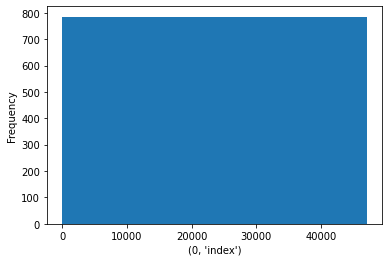

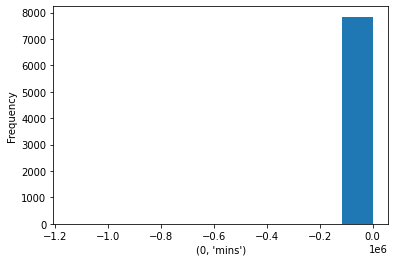

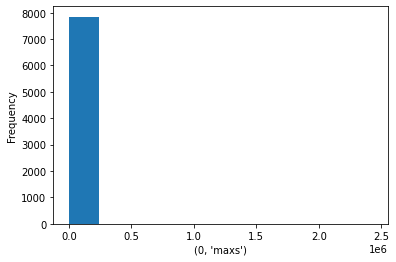

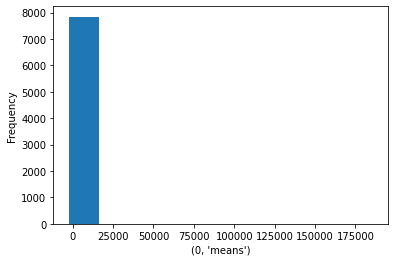

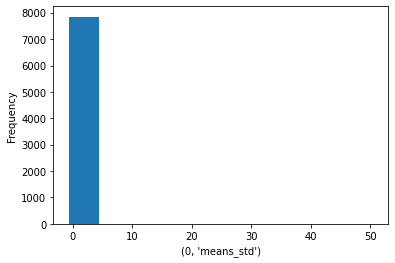

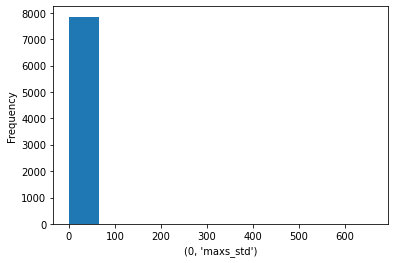

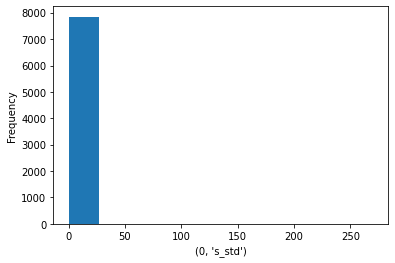

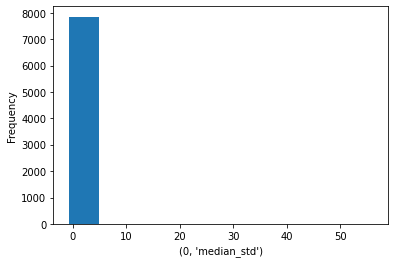

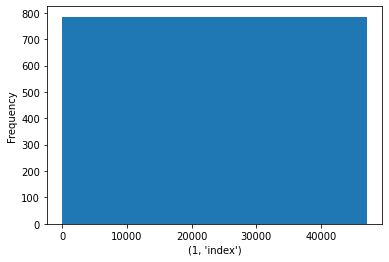

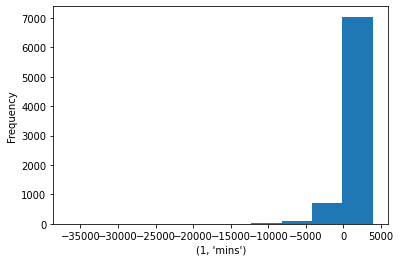

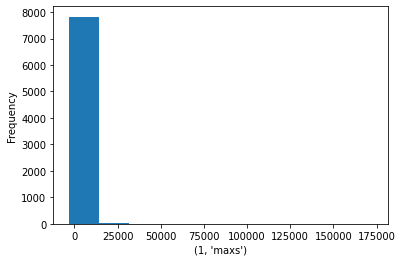

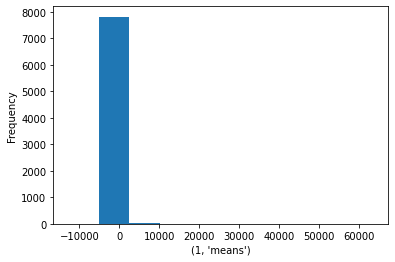

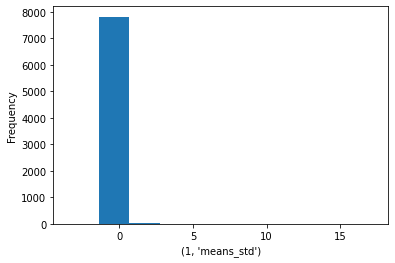

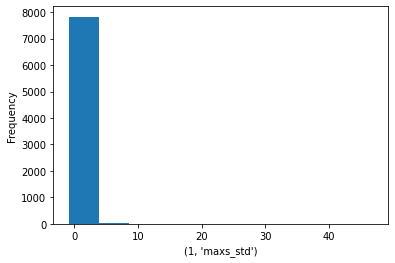

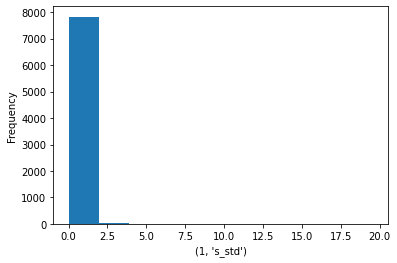

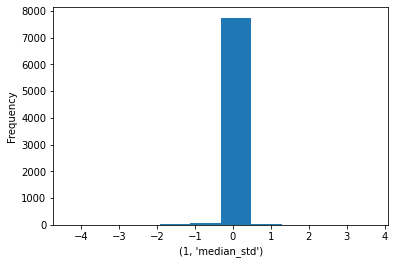

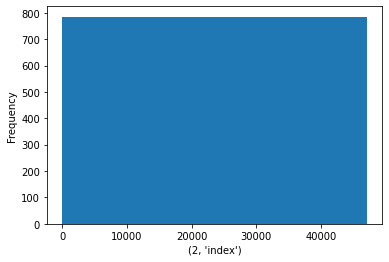

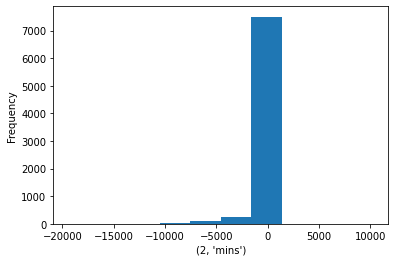

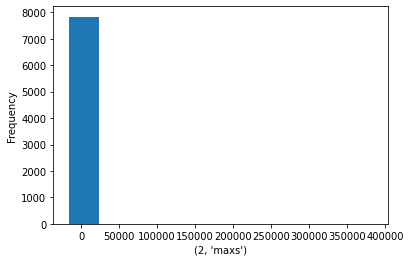

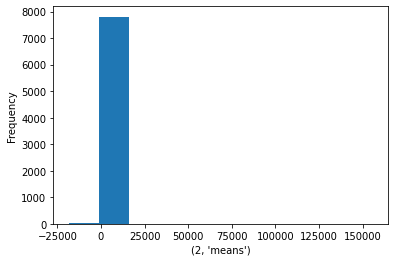

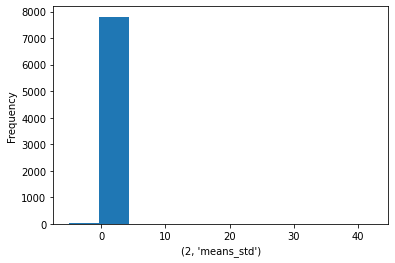

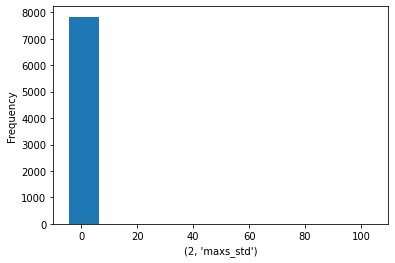

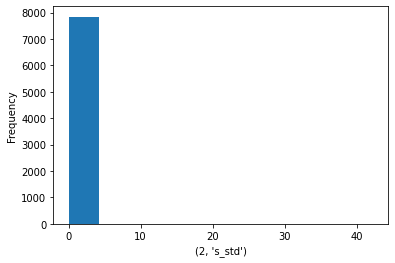

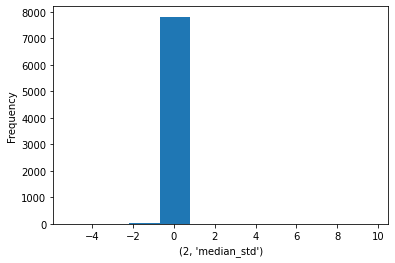

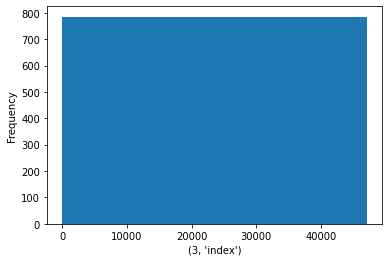

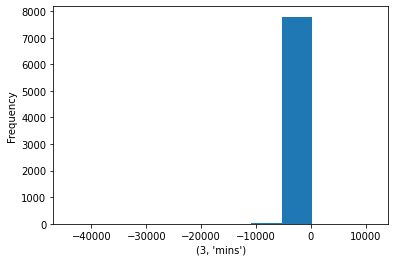

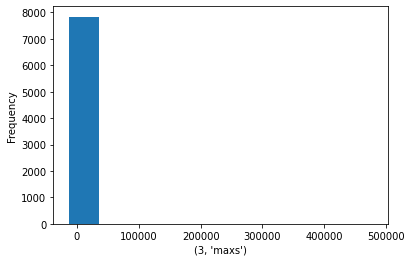

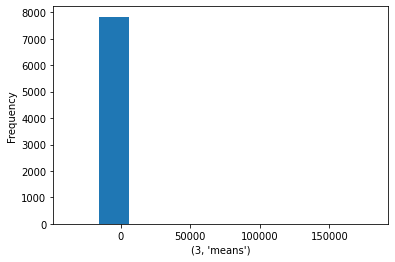

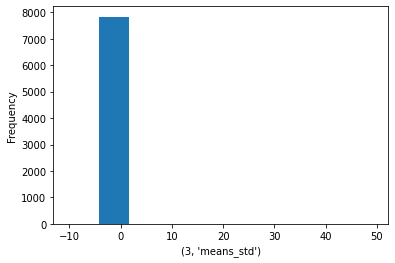

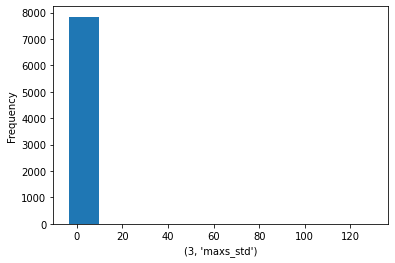

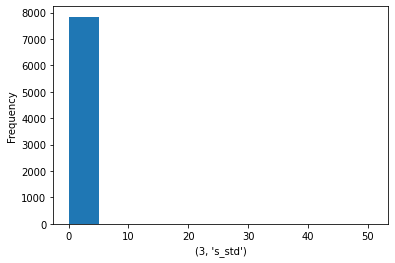

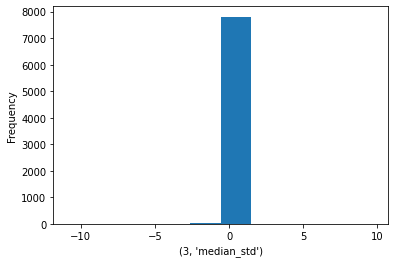

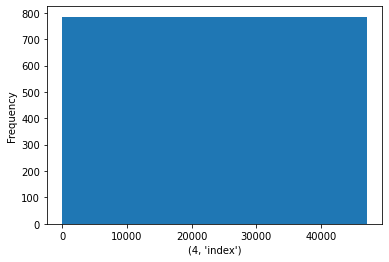

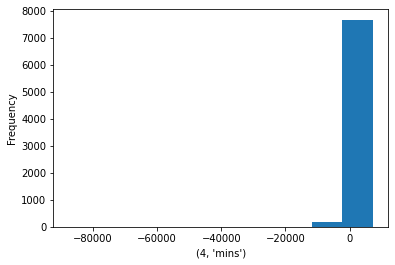

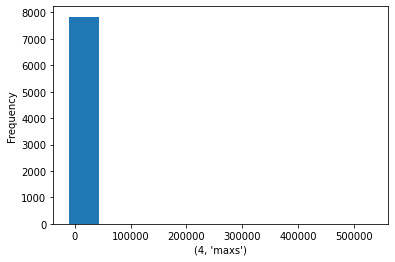

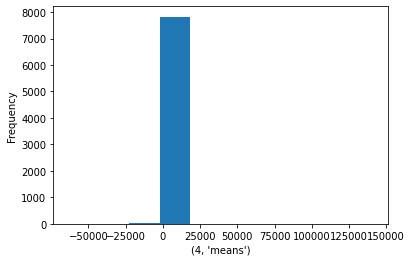

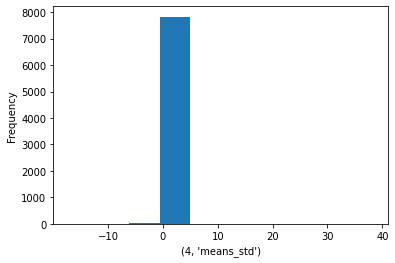

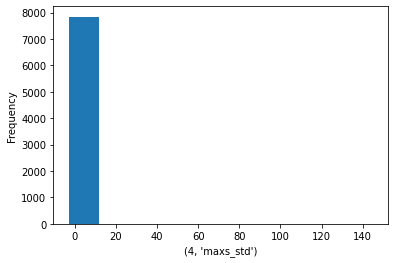

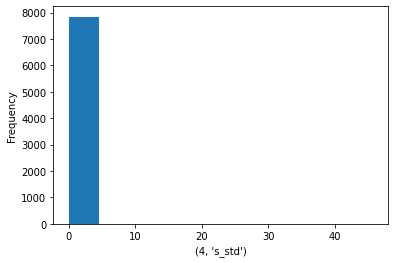

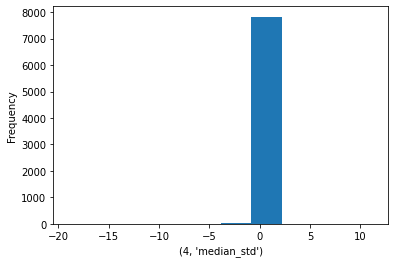

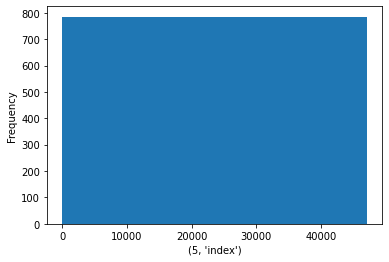

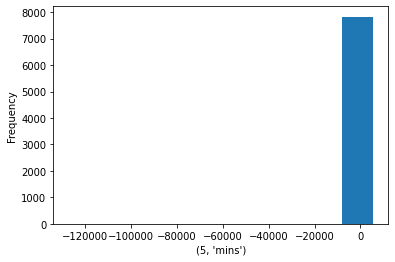

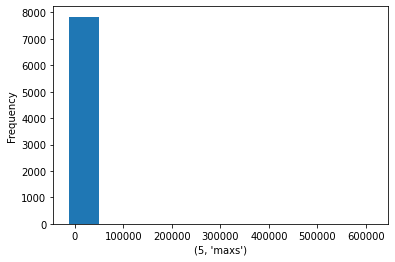

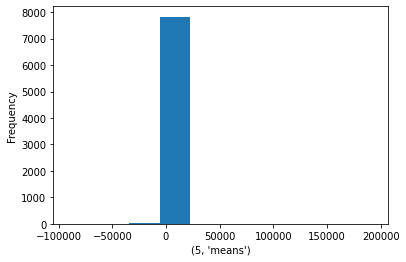

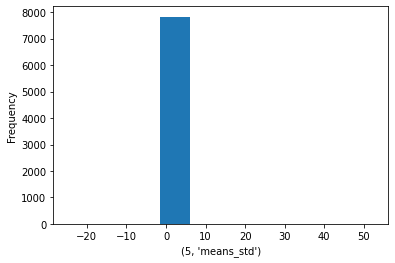

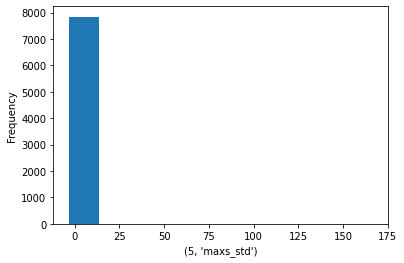

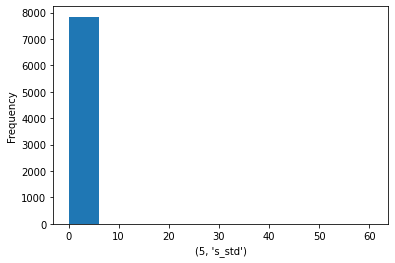

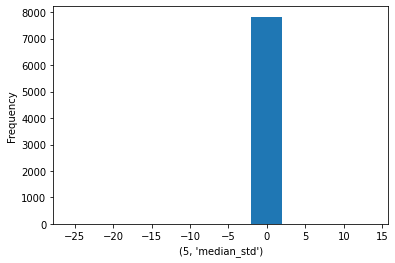

In [675]:
for i in allfeatures.columns:
  pl.figure()
  pl.hist(allfeatures[i])
  pl.xlabel(i)
  pl.ylabel('Frequency')

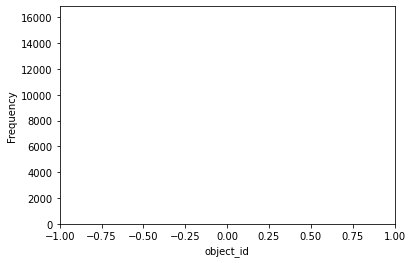

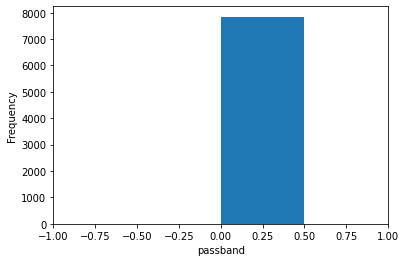

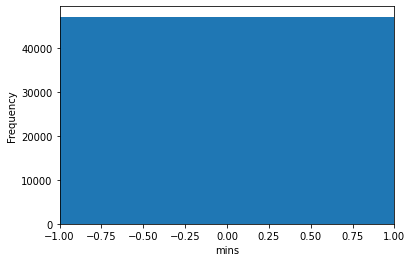

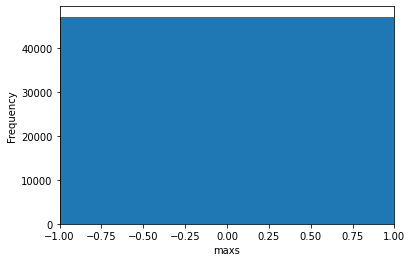

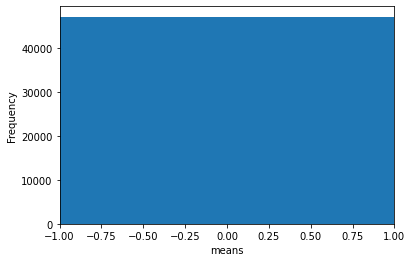

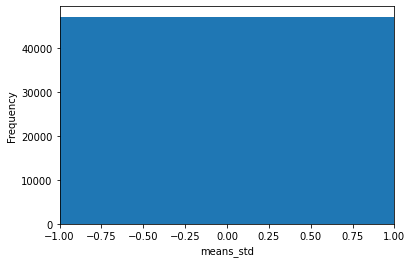

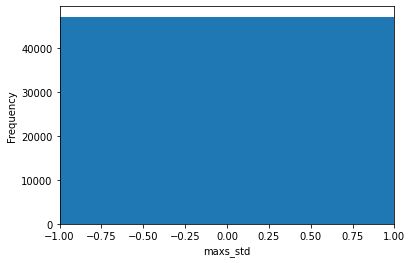

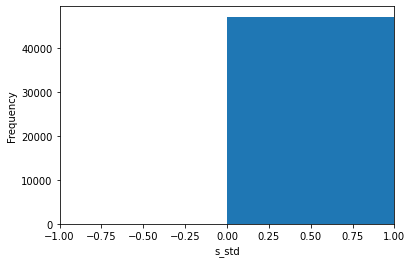

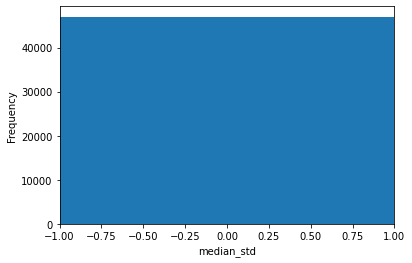

In [672]:
for i in features.columns:
  pl.figure()
  pl.hist(features[i])
  pl.xlabel(i)
  pl.xlim([-1, 1])
  pl.ylabel('Frequency')

# TASK III : Gaussian Processes

Take the time series and fit them with GPs. 
- use the george package goerge (see class demo https://github.com/fedhere/MLTSA22_FBianco/blob/main/Lab5GP/GP_examples.ipynb)
- make sure you use the standardized time series
- make sure you process the uncertainty as well as the data in the standardization!
- choose an appropriate kernel (e.g. the composite one we use in class that enables periodicity as well as stockastic variations)
- take a subset of the time series, ~10, making sure that they are of different types
- fit the GP kernerl to each time series band by band
- collect the best fit parameters and describe their variance - can all the time series be fit reasonably with the same kernel? how would you initialize the fit for the whole ensamble?



In [398]:
!pip install george

In [399]:
import george
from george import kernels
import warnings
warnings.filterwarnings("ignore")

In [414]:
from scipy.optimize import minimize
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

In [417]:
# make sure to standardize
# standardize 
flux_std = preprocessing.scale(purple.flux)
purple['flux_std'] = flux_std
flux_err_std = preprocessing.scale(purple.flux_err)
purple['flux_err_std'] = flux_err_std;

flux_std = preprocessing.scale(blue.flux)
blue['flux_std'] = flux_std
flux_err_std = preprocessing.scale(blue.flux_err)
blue['flux_err_std'] = flux_err_std;

flux_std = preprocessing.scale(green.flux)
green['flux_std'] = flux_std
flux_err_std = preprocessing.scale(green.flux_err)
green['flux_err_std'] = flux_err_std;

flux_std = preprocessing.scale(orange.flux)
orange['flux_std'] = flux_std
flux_err_std = preprocessing.scale(orange.flux_err)
orange['flux_err_std'] = flux_err_std;

flux_std = preprocessing.scale(red.flux)
red['flux_std'] = flux_std
flux_err_std = preprocessing.scale(red.flux_err)
red['flux_err_std'] = flux_err_std;

flux_std = preprocessing.scale(black.flux)
black['flux_std'] = flux_std
flux_err_std = preprocessing.scale(black.flux_err)
black['flux_err_std'] = flux_err_std;

In [419]:
# choose kernel that enables periodicity as well as stockastic variations
kernel = np.var(purple.flux_std) * kernels.Product(kernels.ExpSquaredKernel(0.5), 
                                     kernels.CosineKernel(1))

In [366]:
#kernel = np.var(purple.flux_std) * kernels.ExpSquaredKernel(0.5)

Initial ln-likelihood: -43.32


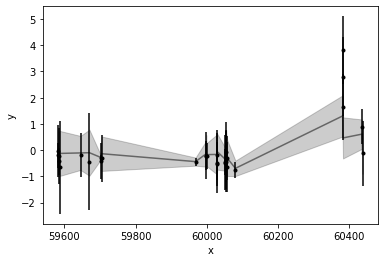

In [394]:
# fit gp kernel to ts band by band
gp = george.GP(kernel)
gp.compute(purple.mjd, purple.flux_err_std) # fit without errors

pred, pred_var = gp.predict(purple.flux_std, purple.mjd.T, return_var=True)

pl.fill_between(purple.mjd.T.ravel(), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha = 0.2)
pl.plot(purple.mjd.T.ravel(), pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(purple.mjd, purple.flux_std, yerr=purple.flux_err_std, fmt=".k", capsize=0)
pl.xlabel("x")
pl.ylabel("y");

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(purple.flux_std)))



Initial ln-likelihood: -43.32
Initial ln-likelihood: -69.44
Initial ln-likelihood: -70.91
Initial ln-likelihood: -71.68
Initial ln-likelihood: -70.62
Initial ln-likelihood: -60.72


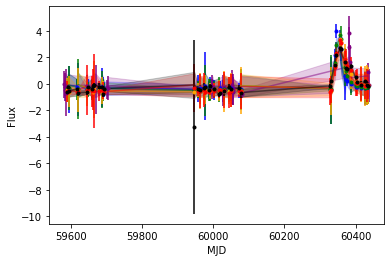

In [420]:
# make loop to do it for all bands
bands_t = [purple.mjd, blue.mjd, green.mjd, orange.mjd, red.mjd, black.mjd]
bands_y = [purple.flux_std, blue.flux_std, green.flux_std, orange.flux_std, red.flux_std, black.flux_std]
bands_yerr = [purple.flux_err_std, blue.flux_err_std, green.flux_err_std, orange.flux_err_std, red.flux_err_std, black.flux_err_std]
color = ["purple", "blue", "green", "orange", "red", "black"]

for i in range(0,6):
    t = bands_t[i]
    y = bands_y[i]
    yerr = bands_yerr[i]
    t_pred = bands_t[i].T

    gp = george.GP(kernel)
    gp.compute(t, yerr) # fit without errors

    pred, pred_var = gp.predict(y, t_pred, return_var=True)

    pl.fill_between(t_pred.ravel(), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color= color[i], alpha=0.2)
    pl.plot(t_pred.ravel(), pred, color = color[i], lw=1.5, alpha=0.5)
    pl.errorbar(t, y, yerr=yerr, fmt=".", color= color[i], capsize=0)
    pl.xlabel("MJD")
    pl.ylabel("Flux");
    print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

In [421]:
from scipy.optimize import minimize
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)
gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
print("Optimized parameters: {0:.2f}".format(*gp.get_parameter_vector()))

      fun: 44.23288313484166
 hess_inv: array([[8.28520883e-02, 2.48511817e-02, 5.85444554e-04],
       [2.48511817e-02, 6.32381790e-02, 2.82328084e-04],
       [5.85444554e-04, 2.82328084e-04, 7.08816085e-05]])
      jac: array([-2.97712894e-07,  1.25212686e-07,  3.79914746e-06])
  message: 'Optimization terminated successfully.'
     nfev: 43
      nit: 13
     njev: 43
   status: 0
  success: True
        x: array([-0.08113567,  4.85043672,  1.08202656])

Final ln-likelihood: -44.23
Optimized parameters: -0.08


Optimized parameters -0.08 4.85
Optimized ln-likelihood: -44.23


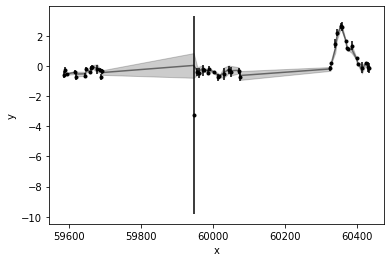

In [413]:
gp.set_parameter_vector(result.x)

pred, pred_var = gp.predict(y, t_pred, return_var=True)
pl.figure()
pl.fill_between(t_pred.ravel(), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(t_pred.ravel(), pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
pl.xlabel("x")
pl.ylabel("y");

print("Optimized parameters {:.2f} {:.2f}".format(*gp.get_parameter_vector()))
print("Optimized ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))


Final ln-likelihood: -43.17
Optimized parameters: -0.08
Final ln-likelihood: -64.24
Optimized parameters: -0.08
Final ln-likelihood: -64.55
Optimized parameters: -0.08
Final ln-likelihood: -61.58
Optimized parameters: -0.08
Final ln-likelihood: -58.73
Optimized parameters: -0.08
Final ln-likelihood: -44.23
Optimized parameters: -0.08


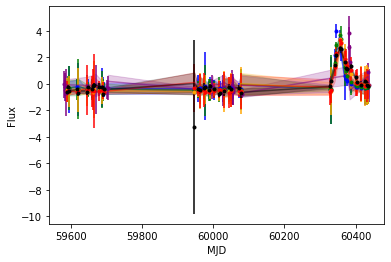

In [412]:
bands_t = [purple.mjd, blue.mjd, green.mjd, orange.mjd, red.mjd, black.mjd]
bands_y = [purple.flux_std, blue.flux_std, green.flux_std, orange.flux_std, red.flux_std, black.flux_std]
bands_yerr = [purple.flux_err_std, blue.flux_err_std, green.flux_err_std, orange.flux_err_std, red.flux_err_std, black.flux_err_std]
color = ["purple", "blue", "green", "orange", "red", "black"]

for i in range(0,6):
    t = bands_t[i]
    y = bands_y[i]
    yerr = bands_yerr[i]
    t_pred = bands_t[i].T

    gp = george.GP(kernel)
    gp.compute(t, yerr) # fit without errors

    pred, pred_var = gp.predict(y, t_pred, return_var=True)

    pl.fill_between(t_pred.ravel(), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                    color=color[i], alpha=0.2)
    pl.plot(t_pred.ravel(), pred, color = color[i], lw=1.5, alpha=0.5)
    pl.errorbar(t, y, yerr=yerr, fmt=".", color = color[i], capsize=0)
    pl.xlabel("MJD")
    pl.ylabel("Flux");
    print("Final ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
    print("Optimized parameters: {0:.2f}".format(*gp.get_parameter_vector()))

# CHALLENGE (Extra Credit): fit the 2D time series: 
- create a 2D array for each of the ~10 time series you used earlier: 1 dimension is time the other is wavelength (the bandpass)
- fit a 2D kernel to the time series. 
- show the fits with their uncertainties marginalized along one feature at a time: the fit along the time axis for all 6 bands and the fit along the wavelength axis for a subset of the datapoints.
- (try and make a surface plot  that conveys the relevant info effectively, I find it difficult)